<a href="https://colab.research.google.com/github/pgarg7/ATMS-597-SP-2020/blob/sarah/project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Background

Imports and Installs

In [3]:
!pip install netcdf4
!pip install pydap
!pip install wget

%pylab inline 
import xarray as xr
import wget
import glob
from bs4 import BeautifulSoup
import requests

     |████████████████████████████████| 4.1MB 2.6MB/s 
     |████████████████████████████████| 317kB 47.8MB/s 
     |████████████████████████████████| 2.3MB 2.7MB/s 
     |████████████████████████████████| 122kB 20.8MB/s 
  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=fe609acc81add062d7ff5ec132508d099a33000e3a79b8f4b2b7b79c54c4d50c
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
Populating the interactive namespace from numpy and matplotlib


Mount Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Define Functions

In [0]:
# Create a function to find months JJA
def is_jja(month):
    return (month >= 6) & (month <= 8)

## Part 1:
Aggregate daily rainfall data from the Global Precipitaiton Climatology Project 1 degree daily precipitation data over the period 1996 - 2019 into a single file from daily files, available here: [https://www.ncei.noaa.gov/data/global-precipitation-climatology-project-gpcp-daily/access/].

In [0]:
url = 'https://www.ncei.noaa.gov/data/global-precipitation-climatology-project-gpcp-daily/access/'
ext = 'nc'

def get_url_paths(url, ext='', params={}):
    response = requests.get(url, params=params)
    if response.ok:
        response_text = response.text
    else:
        return response.raise_for_status()
    soup = BeautifulSoup(response_text, 'html.parser')
    parent = [url + node.get('href') for node in soup.find_all('a') if node.get('href').endswith(ext)]
    return parent

In [0]:
# Loop through all years and grab all of the datasets
years = np.arange(1996,2020)
datasets = []
for i in years:
  result = get_url_paths(url+'{i}/'.format(i=i),ext)
  print('working on {i} '.format(i=i))
  for j in range(len(result)):
    wget.download(result[j])
  files = glob.glob('gpcp*.nc')
  f = xr.open_mfdataset(files,concat_dim='time')
  var = xr.DataArray(f.precip.values,dims=['time','lat','lon'],
                    coords={'time':f.time.values,
                            'lat':f.latitude.values,
                            'lon':f.longitude.values})
  datasets.append(var)
  !rm gpcp*.nc
    #break

In [0]:
# Concatenate the datasets along time dimension
combined = xr.concat(datasets,dim='time')

# Convert to xarray dataset
combined_data = combined.to_dataset(name='precip')

# Convert to netCDF and save
combined_data.to_netcdf('/content/drive/My Drive/ATMS597_Project3_GOCO/GPCP_aggregate.nc',format='NETCDF4')


## Part 2:
Determine the 95% values of daily precipitation during a selected particular 3-month period (given in the table below by group) over the grid box closest to the city you are examining. Plot a cumulative distribution function of all values daily precipitation values and illustrate the 95% value of daily precipitation in millimeters.

In [0]:
# Open the combined dataset
combined_data = xr.open_dataset('/content/drive/My Drive/Colab Notebooks/ATMS597/GPCP_aggregate.nc')

In [0]:
# Slice data for June, July, and August only
jja_data = combined_data.sel(time=is_jja(combined_data['time.month']))

In [0]:
# Find data point: Shanghai, China lat, lon 31.2304° N, 121.4737° E
slat = 31.2304
slon = 121.4737

shanghai_jja = jja_data.sel(lon=slice(slon-1.,slon+1.),lat=slice(slat-1.,slat+1.))

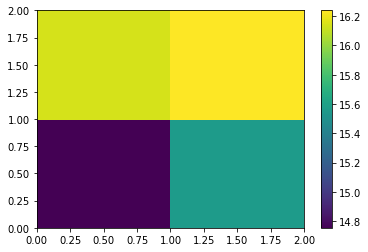

In [9]:
# ????
plt.pcolormesh(shanghai_jja.precip.values[0,:,:])
plt.colorbar()
plt.show()

In [0]:
# Find valid values
valid_ind = np.where((shanghai_jja.precip.values>=0.)&(shanghai_jja.precip.values<=1000.))

In [0]:
# Extract valid values
precip_shanghai = shanghai_jja.precip.values[valid_ind]

In [0]:
# Calculate 95 percentile
perc_95 = np.percentile(precip_shanghai,95)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  from ipykernel import kernelapp as app


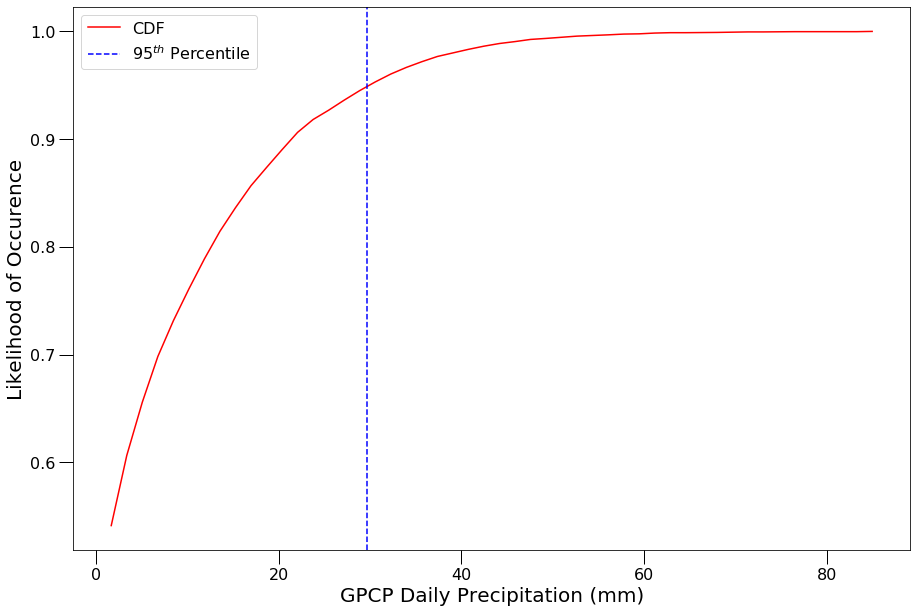

In [13]:
# Plot

# Plotting parameters
mpl.rcParams['xtick.major.size'] = 14
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.size'] = 14
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 14
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 14
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.serif'] = ['Helvetica']
mpl.rc('xtick',labelsize=16)    # Formatting the x ticks
mpl.rc('ytick',labelsize=16)

# Plotting
counts, bin_edges = np.histogram (precip_shanghai, bins=50, normed=True)
cdf = np.cumsum (counts)
plt.figure(figsize=(15,10))
plt.plot (bin_edges[1:], cdf/cdf[-1],'r',label='CDF')
plt.axvline(perc_95,c='b',ls='--',label='$95^{th}$ Percentile')
plt.xlabel('GPCP Daily Precipitation (mm)',fontsize=20)
plt.ylabel('Likelihood of Occurence',fontsize=20)
plt.legend(loc='upper left',fontsize=16)
plt.show()

In [0]:
# Create Dataset for Shanghai significant points
shanghai_95th = shanghai_jja.where(shanghai_jja.precip>=perc_95,drop=True)

## Part 3:
Using output from the NCEP Reanalysis [https://journals.ametsoc.org/doi/pdf/10.1175/1520-0477(1996)077%3C0437%3ATNYRP%3E2.0.CO%3B2] (Kalnay et al. 1996), compute the global mean fields and seasonal anomaly fields for days meeting and exceeding the threshold of precipitation calculated in the previous step (using the 1981-2010 as a base period for anomalies) of

*   250 hPa wind vectors and wind speed,
*   500 hPa winds and geopotential height,
*   850 hPa temperature, specific humidity, and winds,
*   skin temperature, and surface winds,
*   total atmospheric column water vapor.

In [15]:
shanghai_95th

<xarray.Dataset>
Dimensions:  (lat: 2, lon: 2, time: 216)
Coordinates:
  * lat      (lat) float32 31.0 32.0
  * lon      (lon) float32 121.0 122.0
  * time     (time) datetime64[ns] 1997-08-09 1997-08-18 ... 2019-07-04
Data variables:
    precip   (time, lat, lon) float32 41.471333 30.201077 nan ... nan nan

In [24]:
# Wind
uwnd = xr.open_dataset('https://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/pressure/uwnd.day.1981-2010.ltm.nc', engine='netcdf4') 
vwnd = xr.open_dataset('https://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/pressure/vwnd.day.1981-2010.ltm.nc', engine='netcdf4')

# Geopotential height
z500 = xr.open_dataset('https://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/pressure/hgt.day.1981-2010.ltm.nc', engine='netcdf4')

# Temperature
air = xr.open_dataset('https://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/pressure/air.day.1981-2010.ltm.nc', engine='netcdf4')

# Specific humidity
shum = xr.open_dataset('https://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/pressure/shum.day.1981-2010.ltm.nc', engine='netcdf4')

# Skin Temperature
# ??????

# Total Atmospheric Column Water Vapor
# ??????

/usr/local/lib/python3.6/dist-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time ax

### 250 hPa wind vectors and wind speed

### 500 hPa winds and geopotential height

### 850 hPa temperature, specific humidity, and winds

### Skin temperature and surface winds

### Total atmospheric column water vapor

## Part 4:
Create maps showing the mean fields for the extreme precipitation day composites, long term mean composites for the selected months, and the anomaly fields for each variable. Use contours and vectors when appropriate.